In [328]:
import pandas as pd

# 1. Leer los archivos CSV
inv_df = pd.read_csv("Data/Inv.csv", sep=",")
offline_df = pd.read_csv("Data/Offline.csv", sep=",")
time_df = pd.read_csv("Data/Time.csv", sep=",")
visit_df = pd.read_csv("Data/Visit.csv", sep=",")
web_df = pd.read_csv("Data/Web.csv", sep=",")

# 2. Convertir ID_Date a datetime en todos los dataframes (YYYY-MM-01)
for df in [inv_df, offline_df, time_df, visit_df, web_df]:
    df["ID_Date"] = pd.to_datetime(df["ID_Date"], format="%Y%m")

# 3. Unir todos los datasets por ID_Date
df_combined = web_df \
    .merge(visit_df, on="ID_Date", how="left") \
    .merge(offline_df, on="ID_Date", how="left") \
    .merge(time_df, on="ID_Date", how="left") \
    .merge(inv_df, on="ID_Date", how="left")

# 4. Renombrar columna ID_Date a Fecha
df_combined.rename(columns={"ID_Date": "Fecha"}, inplace=True)

# 5. Crear columnas de eventos a nivel mensual
df_combined["Navidad"] = df_combined["Fecha"].dt.month.apply(lambda x: 1 if x == 12 else 0)
df_combined["Black_Friday"] = df_combined["Fecha"].dt.month.apply(lambda x: 1 if x == 11 else 0)
df_combined["Semana_Santa"] = df_combined["Fecha"].dt.month.apply(lambda x: 1 if x in [3, 4] else 0)

# 6. (Opcional) Formatear Fecha como YYYY-MM (para visualizar mejor en CSV)
df_combined["Fecha"] = df_combined["Fecha"].dt.strftime("%Y-%m")

print("✅ Dataset combinado y eventos añadidos correctamente (con Fecha como Año-Mes).")

✅ Dataset combinado y eventos añadidos correctamente (con Fecha como Año-Mes).


In [329]:
df_combined

,Fecha,Unique_visitors,PDFBrochuresDownloaded,ProductConfigurator,Product_configurator_Visists,SocialNetworks,DirectTraffic,EMail,NaturalSearch,OnlineMedia,...,PRENSA,PRODUCCION,RADIO,REVISTAS,PlataformasVideo,VARIOS,INV_Total,Navidad,Black_Friday,Semana_Santa
0,2022-01,272382,4838,33222,94248,1415,65373,25,167199,63649,...,0,6050,"2426,4","18013,5","338824,94","7531,030000000001","574600,14",0,0,0
1,2022-02,352581,5823,38570,109531,546,77209,26,176733,124861,...,10000,6700,0,"49110,909999999996","487537,14","6972,02","916515,0800000001",0,0,0
2,2022-03,332955,4845,33956,97805,5444,83178,341,173514,104132,...,4500,3700,0,0,75000,"15284,85","367522,47",0,0,1
3,2022-04,282169,3711,45949,90689,1184,69335,162,162805,74044,...,48800,21550,1140,40876,"610865,8899999999","12255,75","941187,9099999999",0,0,1
4,2022-05,261829,9037,48685,92069,8648,70972,210,156011,44196,...,11000,4900,"102851,86000000002","20775,75","393807,7400000001","7926,459999999999","746390,17",0,0,0
5,2022-06,201141,10727,38608,73421,1082,61455,2374,134355,15600,...,0,12250,"5526,49","75573,13",0,"5405,719999999999","203983,00000000003",0,0,0
6,2022-07,206538,11023,38912,74564,909,66835,204,144300,11000,...,0,650,"158,4",2600,1500,"4574,5","130196,56999999999",0,0,0
7,2022-08,259903,15743,47613,88335,7511,78704,14,172986,15205,...,13000,9750,"345,6",33860,"391987,8699999999","28716,26","524021,7399999999",0,0,0
8,2022-09,261618,14130,44164,83840,1773,58630,199,174125,41832,...,"9507,8",7850,"2686,8",14580,0,"6645,2699999999995","158223,58",0,0,0
9,2022-10,396642,16321,53200,100262,2117,74040,874,203699,162588,...,0,20300,3162,"117786,97","804181,4000000003","14421,129999999997","1277335,3600000003",0,0,0


In [330]:
# Reemplazar comas por puntos y convertir a numérico donde sea necesario
for col in df_combined.columns:
    if df_combined[col].dtype == 'object':
        df_combined[col] = df_combined[col].str.replace(',', '.', regex=False)
        df_combined[col] = pd.to_numeric(df_combined[col], errors='ignore')  # Solo convierte si se puede


C:\Users\aserr\AppData\Local\Temp\ipykernel_8028\700684367.py:5: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_combined[col] = pd.to_numeric(df_combined[col], errors='ignore')  # Solo convierte si se puede


In [331]:
# Guardar la columna 'Fecha' aparte
fecha_col = df_combined['Fecha']

# Convertir todo lo demás a numérico
df_combined = df_combined.drop(columns=['Fecha'])
df_combined = df_combined.apply(pd.to_numeric, errors='coerce')

# Volver a agregar la columna 'Fecha' como texto en formato "YYYY-MM"
df_combined['Fecha'] = pd.to_datetime(fecha_col).dt.strftime('%Y-%m')


C:\Users\aserr\AppData\Local\Temp\ipykernel_8028\561306165.py:16: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\aserr\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


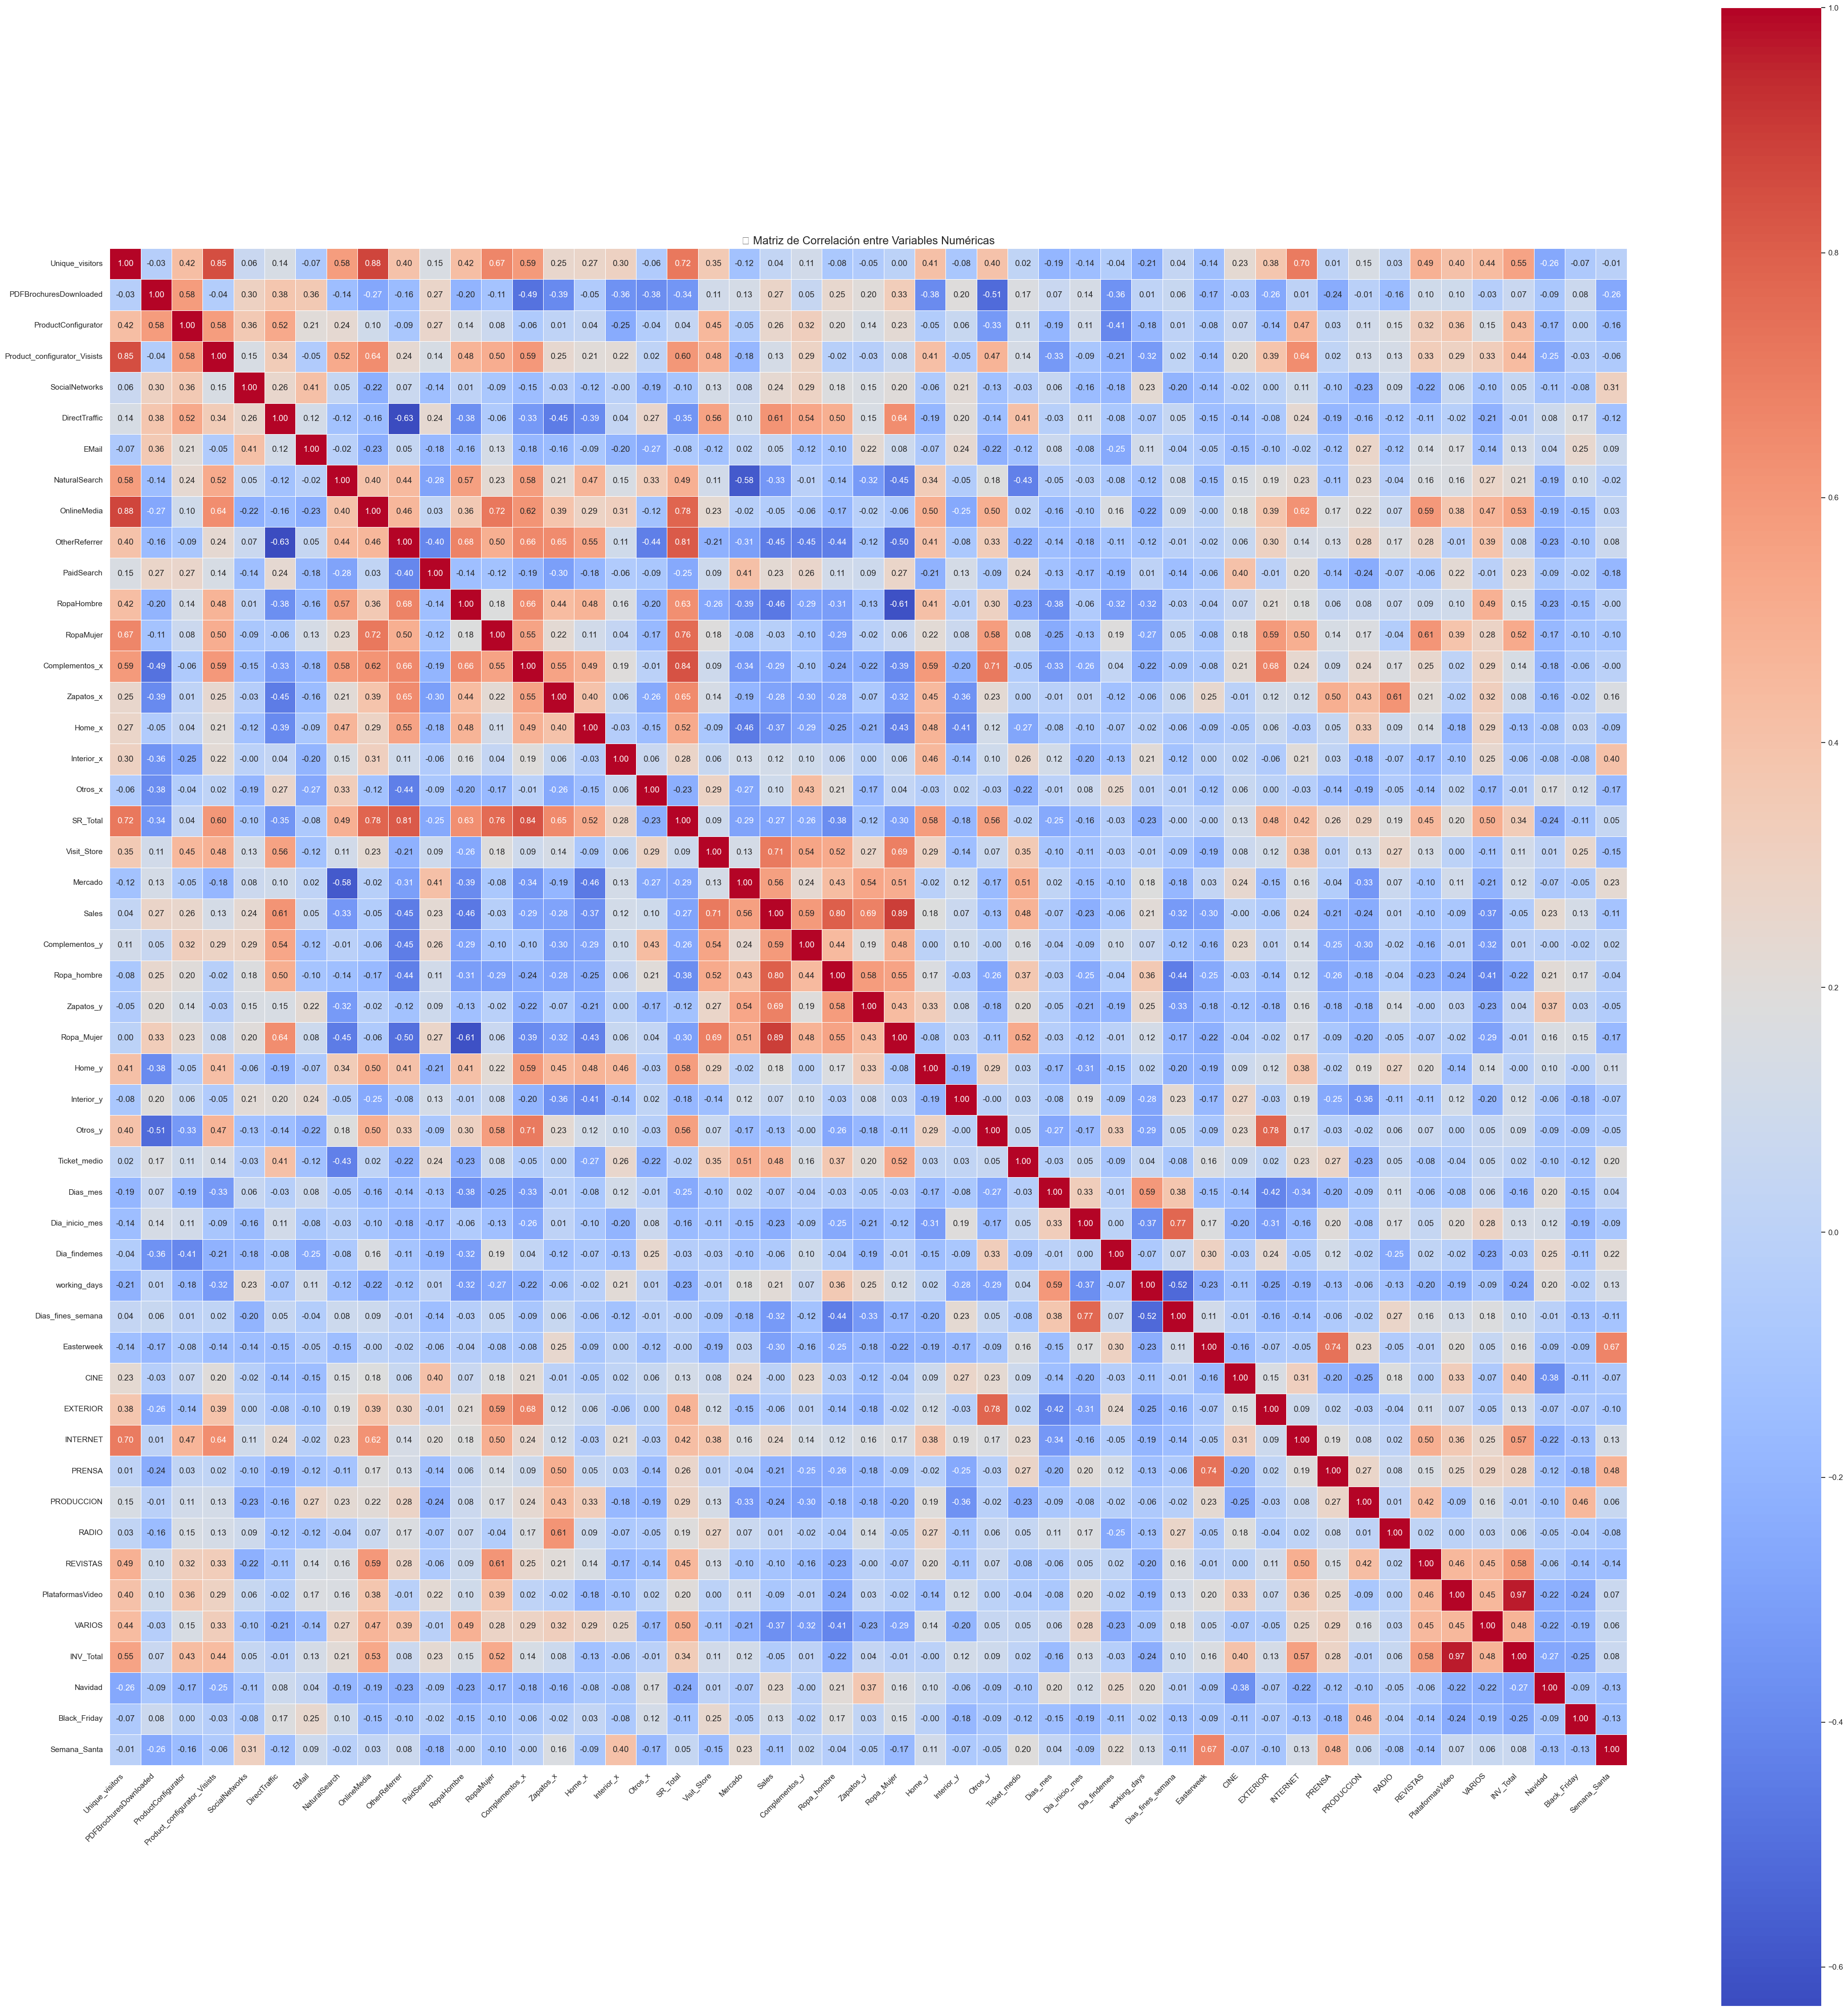

In [332]:
import matplotlib.pyplot as plt
import seaborn as sns

# Asegurarse de excluir la columna 'Fecha' y usar solo numéricas
df_numericas = df_combined.select_dtypes(include='number')

# Calcular la matriz de correlación
corr = df_numericas.corr()

# Graficar la matriz con seaborn
plt.figure(figsize=(40, 40))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=.5)
plt.title("🔍 Matriz de Correlación entre Variables Numéricas", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [333]:
df_combined

,Unique_visitors,PDFBrochuresDownloaded,ProductConfigurator,Product_configurator_Visists,SocialNetworks,DirectTraffic,EMail,NaturalSearch,OnlineMedia,OtherReferrer,...,PRODUCCION,RADIO,REVISTAS,PlataformasVideo,VARIOS,INV_Total,Navidad,Black_Friday,Semana_Santa,Fecha
0,272382,4838,33222,94248,1415,65373,25,167199,63649,39808,...,6050.00,2426.40,18013.5000,338824.940,7531.0300,5.746001e+05,0,0,0,2022-01
1,352581,5823,38570,109531,546,77209,26,176733,124861,45543,...,6700.00,0.00,49110.9100,487537.140,6972.0200,9.165151e+05,0,0,0,2022-02
2,332955,4845,33956,97805,5444,83178,341,173514,104132,43583,...,3700.00,0.00,0.0000,75000.000,15284.8500,3.675225e+05,0,0,1,2022-03
3,282169,3711,45949,90689,1184,69335,162,162805,74044,39650,...,21550.00,1140.00,40876.0000,610865.890,12255.7500,9.411879e+05,0,0,1,2022-04
4,261829,9037,48685,92069,8648,70972,210,156011,44196,40472,...,4900.00,102851.86,20775.7500,393807.740,7926.4600,7.463902e+05,0,0,0,2022-05
5,201141,10727,38608,73421,1082,61455,2374,134355,15600,35272,...,12250.00,5526.49,75573.1300,0.000,5405.7200,2.039830e+05,0,0,0,2022-06
6,206538,11023,38912,74564,909,66835,204,144300,11000,35674,...,650.00,158.40,2600.0000,1500.000,4574.5000,1.301966e+05,0,0,0,2022-07
7,259903,15743,47613,88335,7511,78704,14,172986,15205,42545,...,9750.00,345.60,33860.0000,391987.870,28716.2600,5.240217e+05,0,0,0,2022-08
8,261618,14130,44164,83840,1773,58630,199,174125,41832,41167,...,7850.00,2686.80,14580.0000,0.000,6645.2700,1.582236e+05,0,0,0,2022-09
9,396642,16321,53200,100262,2117,74040,874,203699,162588,45763,...,20300.00,3162.00,117786.9700,804181.400,14421.1300,1.277335e+06,0,0,0,2022-10


In [334]:
# Seleccionar solo las columnas numéricas
df_numeric = df_combined.select_dtypes(include=['number'])

# Calcular la correlación de todas las columnas numéricas con 'Sales'
corr_sales = df_numeric.corr()['Sales'].sort_values(ascending=False)

# Mostrar la correlación con 'Sales'
print("Correlación con Sales:")
print(corr_sales)


Correlación con Sales:
Sales                           1.000000
Ropa_Mujer                      0.894943
Ropa_hombre                     0.799824
Visit_Store                     0.713005
Zapatos_y                       0.686925
DirectTraffic                   0.613117
Complementos_y                  0.590911
Mercado                         0.564543
Ticket_medio                    0.481195
PDFBrochuresDownloaded          0.274405
ProductConfigurator             0.259939
INTERNET                        0.243111
SocialNetworks                  0.239081
Navidad                         0.231766
PaidSearch                      0.225588
working_days                    0.214987
Home_y                          0.182781
Black_Friday                    0.132872
Product_configurator_Visists    0.126808
Interior_x                      0.117267
Otros_x                         0.100038
Interior_y                      0.071522
EMail                           0.051827
Unique_visitors                 0.

In [335]:
import pandas as pd

# Asegúrate de que las columnas numéricas estén bien formateadas
df_combined['Sales'] = pd.to_numeric(df_combined['Sales'], errors='coerce')
df_combined['Unique_visitors'] = pd.to_numeric(df_combined['Unique_visitors'], errors='coerce')

# Crear la variable ventas/tráfico
df_combined['Ventas_Trafico'] = df_combined['Sales'] / df_combined['Unique_visitors']
df_combined['Ventas_Trafico_Lag1'] = df_combined['Ventas_Trafico'].shift(1)

# Crear las variables rezagadas
df_combined['Ventas_Lag1'] = df_combined['Sales'].shift(1)
df_combined['Trafico_Lag1'] = df_combined['Unique_visitors'].shift(1)

# Crear otras variables como el crecimiento de ventas y tráfico
df_combined['Crecimiento_Ventas'] = (df_combined['Sales'] - df_combined['Ventas_Lag1']) / df_combined['Ventas_Lag1']
df_combined['Crecimiento_Trafico'] = (df_combined['Unique_visitors'] - df_combined['Trafico_Lag1']) / df_combined['Trafico_Lag1']

# Eliminar filas con NaN (por los lags)
df_combined.dropna(inplace=True)


In [336]:
df_combined

,Unique_visitors,PDFBrochuresDownloaded,ProductConfigurator,Product_configurator_Visists,SocialNetworks,DirectTraffic,EMail,NaturalSearch,OnlineMedia,OtherReferrer,...,Navidad,Black_Friday,Semana_Santa,Fecha,Ventas_Trafico,Ventas_Trafico_Lag1,Ventas_Lag1,Trafico_Lag1,Crecimiento_Ventas,Crecimiento_Trafico
1,352581,5823,38570,109531,546,77209,26,176733,124861,45543,...,0,0,0,2022-02,0.004969,0.004769,1299.0,272382.0,0.348730,0.294436
2,332955,4845,33956,97805,5444,83178,341,173514,104132,43583,...,0,0,1,2022-03,0.005697,0.004969,1752.0,352581.0,0.082763,-0.055664
3,282169,3711,45949,90689,1184,69335,162,162805,74044,39650,...,0,0,1,2022-04,0.005479,0.005697,1897.0,332955.0,-0.185029,-0.152531
4,261829,9037,48685,92069,8648,70972,210,156011,44196,40472,...,0,0,0,2022-05,0.006814,0.005479,1546.0,282169.0,0.153946,-0.072084
5,201141,10727,38608,73421,1082,61455,2374,134355,15600,35272,...,0,0,0,2022-06,0.009038,0.006814,1784.0,261829.0,0.019058,-0.231785
6,206538,11023,38912,74564,909,66835,204,144300,11000,35674,...,0,0,0,2022-07,0.007664,0.009038,1818.0,201141.0,-0.129263,0.026832
7,259903,15743,47613,88335,7511,78704,14,172986,15205,42545,...,0,0,0,2022-08,0.004394,0.007664,1583.0,206538.0,-0.278585,0.258379
8,261618,14130,44164,83840,1773,58630,199,174125,41832,41167,...,0,0,0,2022-09,0.005890,0.004394,1142.0,259903.0,0.349387,0.006599
9,396642,16321,53200,100262,2117,74040,874,203699,162588,45763,...,0,0,0,2022-10,0.003999,0.005890,1541.0,261618.0,0.029202,0.516111
10,249824,12549,41706,80311,1718,67089,4366,179778,17594,42170,...,0,1,0,2022-11,0.006252,0.003999,1586.0,396642.0,-0.015132,-0.370152


In [337]:
'''from sklearn.preprocessing import MinMaxScaler

# Lista de columnas a escalar
cols_to_scale = ['CINE', 'EXTERIOR', 'INTERNET', 'PRENSA', 'PRODUCCION', 'RADIO', 'REVISTAS', 'PlataformasVideo', 'VARIOS']

# Filtrar solo las que realmente existen en el DataFrame (por si acaso alguna faltara)
cols_to_scale = [col for col in cols_to_scale if col in df_combined.columns]

# Aplicar MinMaxScaler
scaler = MinMaxScaler()
df_combined[cols_to_scale] = scaler.fit_transform(df_combined[cols_to_scale])

print("✅ Columnas seleccionadas escaladas correctamente.")
'''

'from sklearn.preprocessing import MinMaxScaler\n\n# Lista de columnas a escalar\ncols_to_scale = [\'CINE\', \'EXTERIOR\', \'INTERNET\', \'PRENSA\', \'PRODUCCION\', \'RADIO\', \'REVISTAS\', \'PlataformasVideo\', \'VARIOS\']\n\n# Filtrar solo las que realmente existen en el DataFrame (por si acaso alguna faltara)\ncols_to_scale = [col for col in cols_to_scale if col in df_combined.columns]\n\n# Aplicar MinMaxScaler\nscaler = MinMaxScaler()\ndf_combined[cols_to_scale] = scaler.fit_transform(df_combined[cols_to_scale])\n\nprint("✅ Columnas seleccionadas escaladas correctamente.")\n'

In [338]:
df_combined

,Unique_visitors,PDFBrochuresDownloaded,ProductConfigurator,Product_configurator_Visists,SocialNetworks,DirectTraffic,EMail,NaturalSearch,OnlineMedia,OtherReferrer,...,Navidad,Black_Friday,Semana_Santa,Fecha,Ventas_Trafico,Ventas_Trafico_Lag1,Ventas_Lag1,Trafico_Lag1,Crecimiento_Ventas,Crecimiento_Trafico
1,352581,5823,38570,109531,546,77209,26,176733,124861,45543,...,0,0,0,2022-02,0.004969,0.004769,1299.0,272382.0,0.348730,0.294436
2,332955,4845,33956,97805,5444,83178,341,173514,104132,43583,...,0,0,1,2022-03,0.005697,0.004969,1752.0,352581.0,0.082763,-0.055664
3,282169,3711,45949,90689,1184,69335,162,162805,74044,39650,...,0,0,1,2022-04,0.005479,0.005697,1897.0,332955.0,-0.185029,-0.152531
4,261829,9037,48685,92069,8648,70972,210,156011,44196,40472,...,0,0,0,2022-05,0.006814,0.005479,1546.0,282169.0,0.153946,-0.072084
5,201141,10727,38608,73421,1082,61455,2374,134355,15600,35272,...,0,0,0,2022-06,0.009038,0.006814,1784.0,261829.0,0.019058,-0.231785
6,206538,11023,38912,74564,909,66835,204,144300,11000,35674,...,0,0,0,2022-07,0.007664,0.009038,1818.0,201141.0,-0.129263,0.026832
7,259903,15743,47613,88335,7511,78704,14,172986,15205,42545,...,0,0,0,2022-08,0.004394,0.007664,1583.0,206538.0,-0.278585,0.258379
8,261618,14130,44164,83840,1773,58630,199,174125,41832,41167,...,0,0,0,2022-09,0.005890,0.004394,1142.0,259903.0,0.349387,0.006599
9,396642,16321,53200,100262,2117,74040,874,203699,162588,45763,...,0,0,0,2022-10,0.003999,0.005890,1541.0,261618.0,0.029202,0.516111
10,249824,12549,41706,80311,1718,67089,4366,179778,17594,42170,...,0,1,0,2022-11,0.006252,0.003999,1586.0,396642.0,-0.015132,-0.370152


### Modelossss

In [339]:
# -------------------------
# 📦 IMPORTACIÓN LIBRERÍAS
# -------------------------
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
import cvxpy as cp

# --------------------------------------
# 🧼 FASE 0: PREPARACIÓN Y AGRUPACIÓN
# --------------------------------------

# Agrupar variables según categorías dadas
inv_digitales = ['INTERNET', 'PlataformasVideo']  # No se tiene Social
inv_tradicionales = ['CINE', 'EXTERIOR', 'PRENSA', 'RADIO', 'REVISTAS']
inv_otros = ['PRODUCCION', 'VARIOS']
variables_inversion = inv_digitales + inv_tradicionales + inv_otros

variables_eventos = ['Navidad', 'Black_Friday', 'Semana_Santa']

variables_temporales = [
    'Ventas_Trafico', 'Ventas_Trafico_Lag1', 'Ventas_Lag1',
    'Trafico_Lag1', 'Crecimiento_Ventas', 'Crecimiento_Trafico'
]

# Crear variables de lag
for col in variables_inversion:
    df_combined[f'{col}_lag1'] = df_combined[col].shift(1)
    df_combined[f'{col}_lag2'] = df_combined[col].shift(2)

# Quitar filas con NaN
df_model = df_combined.dropna()

### Optimizacion pa

# Con los delays y tal

##  FASE 1: Modelo de atribución con Ridge Regression

In [340]:
# ----------------------------
# 🧠 FASE 1: RIDGE REGRESSION
# ----------------------------

# Variables predictoras y target
X = df_model[[f'{col}_lag1' for col in variables_inversion] +
             [f'{col}_lag2' for col in variables_inversion] +
             variables_eventos +
             variables_temporales]

y = df_model['Sales']

# Escalado
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Modelo Ridge
ridge = Ridge(alpha=1.0)
ridge.fit(X_scaled, y)

# Coeficientes
coef = pd.Series(ridge.coef_, index=X.columns)
print("\n🎯 Coeficientes del modelo:")
print(coef.sort_values(ascending=False))


🎯 Coeficientes del modelo:
Ventas_Trafico           172.664399
Crecimiento_Ventas       146.139182
Ventas_Lag1              128.934556
Crecimiento_Trafico      124.258230
Trafico_Lag1              78.400724
PlataformasVideo_lag2     47.390314
INTERNET_lag1             43.232539
PlataformasVideo_lag1     20.386191
RADIO_lag2                19.575220
VARIOS_lag1               16.520303
Black_Friday              15.159495
PRENSA_lag1                7.512902
Navidad                    4.173666
PRENSA_lag2                2.054115
PRODUCCION_lag1            1.315158
EXTERIOR_lag1              0.725433
PRODUCCION_lag2           -1.837761
EXTERIOR_lag2             -5.865393
INTERNET_lag2             -7.222414
REVISTAS_lag2             -8.583348
Ventas_Trafico_Lag1      -12.242484
RADIO_lag1               -13.650519
Semana_Santa             -20.471172
VARIOS_lag2              -24.267852
CINE_lag1                -25.238985
CINE_lag2                -30.366196
REVISTAS_lag1            -53.830824


## FASE 2: Optimización del presupuesto

In [341]:
# ------------------------------
# 📊 FASE 2: OPTIMIZACIÓN CON NUEVOS LÍMITES
# ------------------------------

# Usar solo coeficientes lag1 para optimización
channels = variables_inversion
coef_opt = coef[[f"{c}_lag1" for c in channels]].copy()

# Eliminar coeficientes negativos
coef_opt = coef_opt.apply(lambda x: max(0, x))

# Variables de optimización
x = cp.Variable(len(channels))
coefs_array = coef_opt.values

# Presupuesto base (2024)
budget_2024 = df_combined[channels].sum(axis=1).mean()

# Presupuesto mensual inicial para simulación (enero–junio 2025)
monthly_budget = budget_2024 * 1.15

# Definir límites personalizados por canal (como % del presupuesto)
limites_por_canal = {
    'INTERNET':      {'max': 0.70},
    'PlataformasVideo': {'min': 0.075},
    'CINE':          {'min': 0.05},
    'EXTERIOR':      {'min': 0.04},
    'PRENSA':        {'min': 0.08},
    'RADIO':         {'min': 0.04},
    'REVISTAS':      {'min': 0.02},
    'PRODUCCION':    {'min': 0.03},
    'VARIOS':        {'min': 0.02}
}

# Construir restricciones dinámicamente
constraints = [cp.sum(x) == monthly_budget]

for i, canal in enumerate(channels):
    if 'min' in limites_por_canal.get(canal, {}):
        constraints.append(x[i] >= limites_por_canal[canal]['min'] * monthly_budget)
    if 'max' in limites_por_canal.get(canal, {}):
        constraints.append(x[i] <= limites_por_canal[canal]['max'] * monthly_budget)

# Asegurar que las inversiones sean no negativas
constraints.append(x >= 0)

# Optimización
objective = cp.Maximize(coefs_array @ x)
prob = cp.Problem(objective, constraints)
prob.solve()

# Resultado: inversión optimizada
optimized_investment = dict(zip(channels, x.value.round(2)))
optimized_investment_series = pd.Series(optimized_investment)

# Calcular el porcentaje de cada canal sobre el total
total = optimized_investment_series.sum()
porcentajes = (optimized_investment_series / total * 100).round(2)

# Mostrar inversión con porcentaje
print("\n💰 Inversión optimizada con porcentajes:")
for canal, valor in optimized_investment_series.items():
    print(f"{canal:<15} {valor:>10,.2f} €  ({porcentajes[canal]:>5.2f}%)")

# Agrupación de canales
grupos = {
    'Tradicional': ['PRENSA', 'RADIO', 'REVISTAS', 'EXTERIOR'],
    'Online': ['INTERNET', 'PlataformasVideo'],
    'CINE': ['CINE'],
    'PRODUCCION': ['PRODUCCION'],
    'VARIOS': ['VARIOS']
}

print("\n📦 Inversión por grupo:")
for grupo, canales in grupos.items():
    suma = optimized_investment_series[canales].sum()
    porcentaje = (suma / total) * 100
    print(f"{grupo:<12}: {suma:>10,.2f} €  ({porcentaje:>5.2f}%)")



💰 Inversión optimizada con porcentajes:
INTERNET        427,664.91 €  (64.50%)
PlataformasVideo  49,728.48 €  ( 7.50%)
CINE             33,152.32 €  ( 5.00%)
EXTERIOR         26,521.85 €  ( 4.00%)
PRENSA           53,043.71 €  ( 8.00%)
RADIO            26,521.85 €  ( 4.00%)
REVISTAS         13,260.93 €  ( 2.00%)
PRODUCCION       19,891.39 €  ( 3.00%)
VARIOS           13,260.93 €  ( 2.00%)

📦 Inversión por grupo:
Tradicional : 119,348.34 €  (18.00%)
Online      : 477,393.39 €  (72.00%)
CINE        :  33,152.32 €  ( 5.00%)
PRODUCCION  :  19,891.39 €  ( 3.00%)
VARIOS      :  13,260.93 €  ( 2.00%)


##  FASE 3: Proyección a 6 meses

In [342]:
# ----------------------------------
# 🔮 FASE 3: SIMULACIÓN DE VENTAS
# ----------------------------------

import cvxpy as cp
import pandas as pd

# Asegurar formato de fecha correcto
df_combined['Fecha'] = pd.to_datetime(df_combined['Fecha'], errors='coerce')

# -----------------------------
# Función de optimización por mes
# -----------------------------
def optimizar_inversion(monto, coef_opt, canales, limites):
    x = cp.Variable(len(canales))
    coefs_array = coef_opt.values

    constraints = [cp.sum(x) == monto]

    for i, canal in enumerate(canales):
        if 'min' in limites.get(canal, {}):
            constraints.append(x[i] >= limites[canal]['min'] * monto)
        if 'max' in limites.get(canal, {}):
            constraints.append(x[i] <= limites[canal]['max'] * monto)

    constraints.append(x >= 0)

    objective = cp.Maximize(coefs_array @ x)
    prob = cp.Problem(objective, constraints)
    prob.solve()

    return pd.Series(x.value, index=canales)

# -----------------------------
# Ajustes estacionales / eventos
# -----------------------------
def apply_event_adjustment(month, sales_proj):
    easter = 1.1 if month in df_combined[df_combined['Semana_Santa'] == 1]['Fecha'].dt.month.values else 1.0
    weekend = 1.05 if month in df_combined[df_combined['Dias_fines_semana'] > 0]['Fecha'].dt.month.values else 1.0
    working = 1.02 if month in df_combined[df_combined['working_days'] > 0]['Fecha'].dt.month.values else 1.0
    return sales_proj * easter * weekend * working

# -----------------------------
# Presupuestos mensuales
# -----------------------------
presupuestos = {
    '2025-01': budget_2024 * 1.15,
    '2025-02': budget_2024 * 1.15,
    '2025-03': budget_2024 * 1.15,
    '2025-04': budget_2024 * 1.15,
    '2025-05': budget_2024 * 1.15,
    '2025-06': budget_2024 * 1.15,
    '2025-07': budget_2024 * 1.21,
    '2025-08': budget_2024 * 1.21,
    '2025-09': budget_2024 * 1.21,
    '2025-10': budget_2024 * 1.21,
    '2025-11': budget_2024 * 1.21,
    '2025-12': budget_2024 * 1.21,
    '2026': budget_2024 * 1.25
}

# -----------------------------
# Límites por canal actualizados
# -----------------------------
limites_por_canal = {
    'INTERNET': {'max': 0.70},
    'PlataformasVideo': {'min': 0.075},
    'CINE': {'min': 0.05},
    'EXTERIOR': {'min': 0.04},
    'PRENSA': {'min': 0.08},
    'RADIO': {'min': 0.04},
    'REVISTAS': {'min': 0.02},
    'PRODUCCION': {'min': 0.03},
    'VARIOS': {'min': 0.02}
}

# -----------------------------
# Simulación enero – junio 2025
# -----------------------------
sim_months = pd.date_range(start='2025-01-01', end='2025-06-01', freq='MS')
inv_lag1 = optimized_investment_series.copy()
inv_lag2 = optimized_investment_series.copy()
results = []

for current_month in sim_months:
    month_str = current_month.strftime('%Y-%m')
    monthly_budget = presupuestos.get(month_str, budget_2024)

    # Optimización con presupuesto del mes
    optimized_investment_series = optimizar_inversion(
        monthly_budget,
        coef_opt,
        channels,
        limites_por_canal
    )

    # Proyección de ventas con coef lag1 y lag2
    sales_proj = 0
    for ch in channels:
        c1 = coef.get(f'{ch}_lag1', 0)
        c2 = coef.get(f'{ch}_lag2', 0)
        sales_proj += c1 * inv_lag1[ch] + c2 * inv_lag2[ch]

    # Ajuste por eventos
    sales_proj = apply_event_adjustment(current_month.month, sales_proj)

    results.append({
        'Mes': month_str,
        'Inversión total': round(optimized_investment_series.sum(), 2),
        'Ventas esperadas': round(sales_proj, 2)
    })

    # Actualizar lags
    inv_lag2 = inv_lag1.copy()
    inv_lag1 = optimized_investment_series.copy()

# -----------------------------
# Resultados finales
# -----------------------------
df_results = pd.DataFrame(results)
df_results['Ventas acumuladas'] = df_results['Ventas esperadas'].cumsum()
df_results['Crecimiento mensual (%)'] = df_results['Ventas esperadas'].pct_change().fillna(0).round(3) * 100

print("\n📈 Resultados de la simulación:")
print(df_results)



📈 Resultados de la simulación:
       Mes  Inversión total  Ventas esperadas  Ventas acumuladas  \
0  2025-01        663046.37       17687272.47       1.768727e+07   
1  2025-02        663046.37       17687272.51       3.537454e+07   
2  2025-03        663046.37       19455999.86       5.483054e+07   
3  2025-04        663046.37       19455999.86       7.428654e+07   
4  2025-05        663046.37       17687272.60       9.197382e+07   
5  2025-06        663046.37       17687272.60       1.096611e+08   

   Crecimiento mensual (%)  
0                      0.0  
1                      0.0  
2                     10.0  
3                      0.0  
4                     -9.1  
5                      0.0  



📈 Simulación completa (2025–2026):
        Mes  Inversión total (€)  Ventas esperadas       INTERNET  \
0   2025-01            663046.37       17687272.60  427664.910333   
1   2025-02            663046.37       17687272.60  427664.910333   
2   2025-03            663046.37       19455999.86  427664.910333   
3   2025-04            663046.37       19455999.86  427664.910333   
4   2025-05            663046.37       17687272.60  427664.910333   
5   2025-06            663046.37       17687272.60  427664.910333   
6   2025-07            697640.10       17687272.60  449977.862176   
7   2025-08            697640.10       18707228.92  449977.862176   
8   2025-09            697640.10       18610086.83  449977.862176   
9   2025-10            697640.10       18610086.83  449977.862176   
10  2025-11            697640.10       18610086.83  449977.862176   
11  2025-12            697640.10       18610086.83  449977.862176   
12  2026-01            720702.58       18610086.83  464853.163405  

C:\Users\aserr\AppData\Local\Temp\ipykernel_8028\3680274008.py:144: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\aserr\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


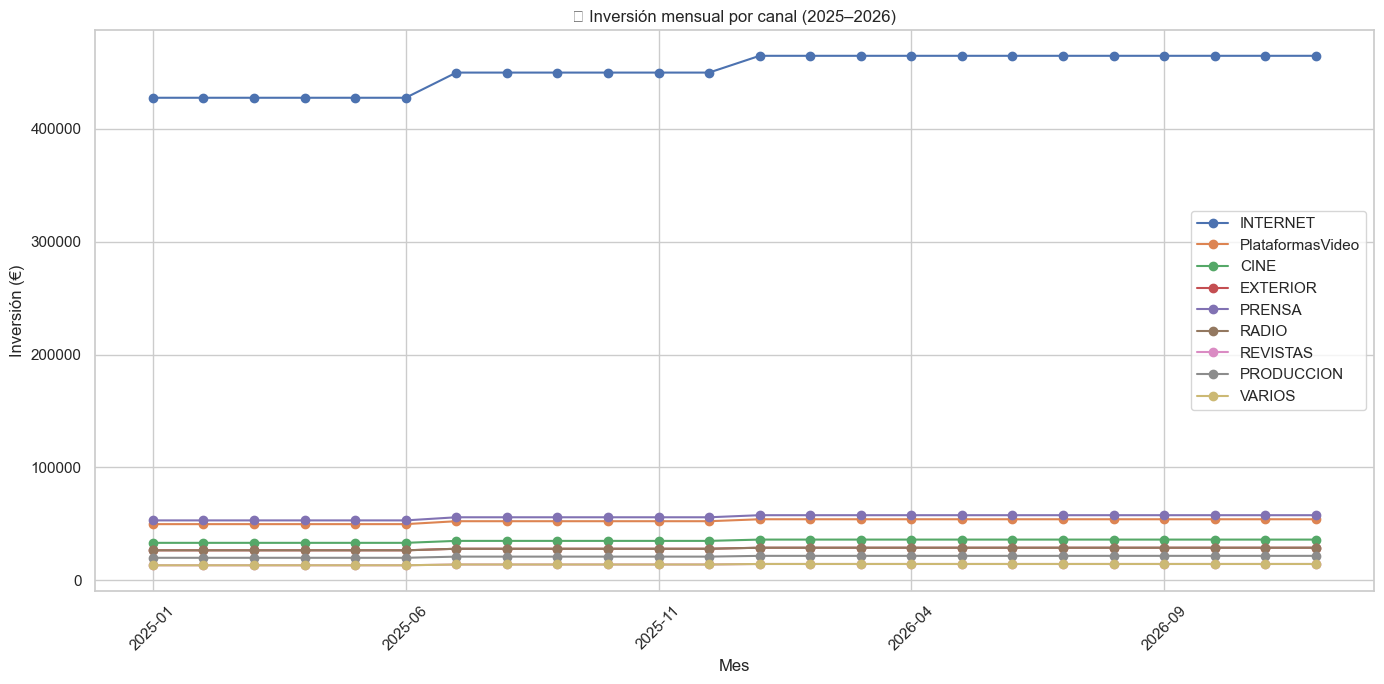

C:\Users\aserr\AppData\Local\Temp\ipykernel_8028\3680274008.py:153: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\aserr\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


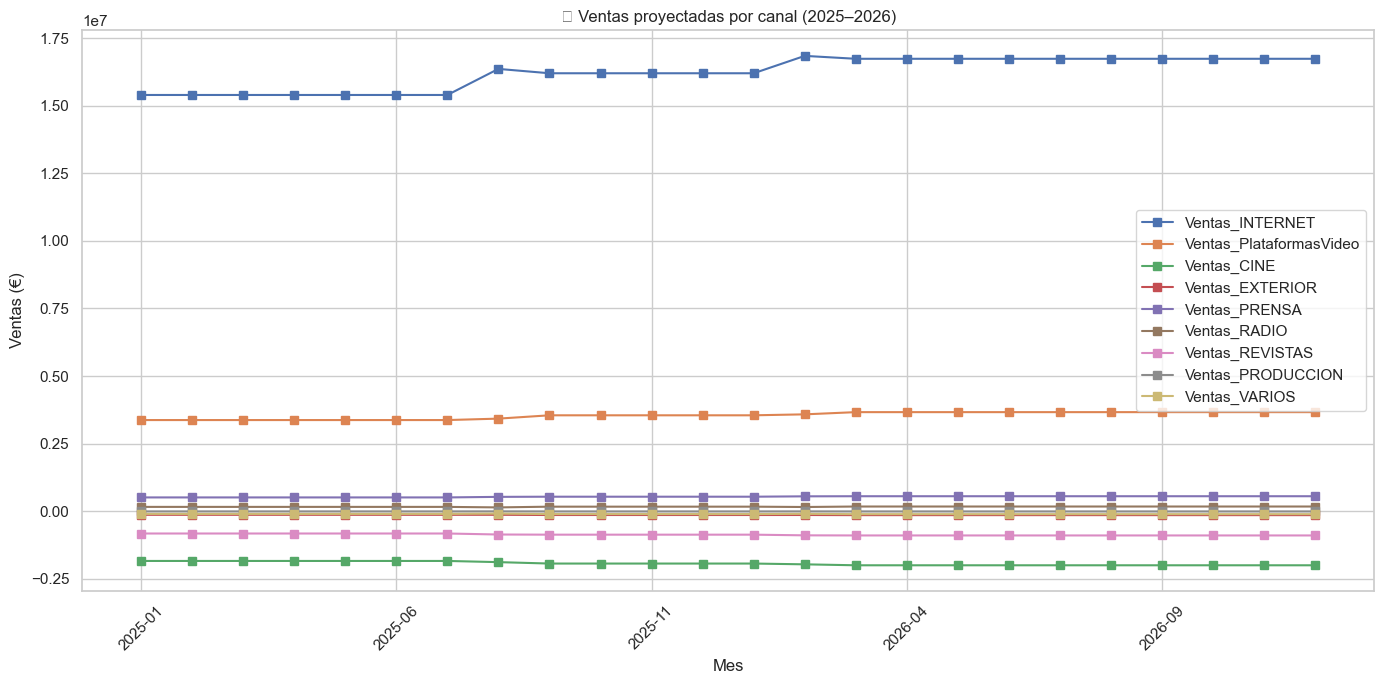

C:\Users\aserr\AppData\Local\Temp\ipykernel_8028\3680274008.py:166: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\aserr\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


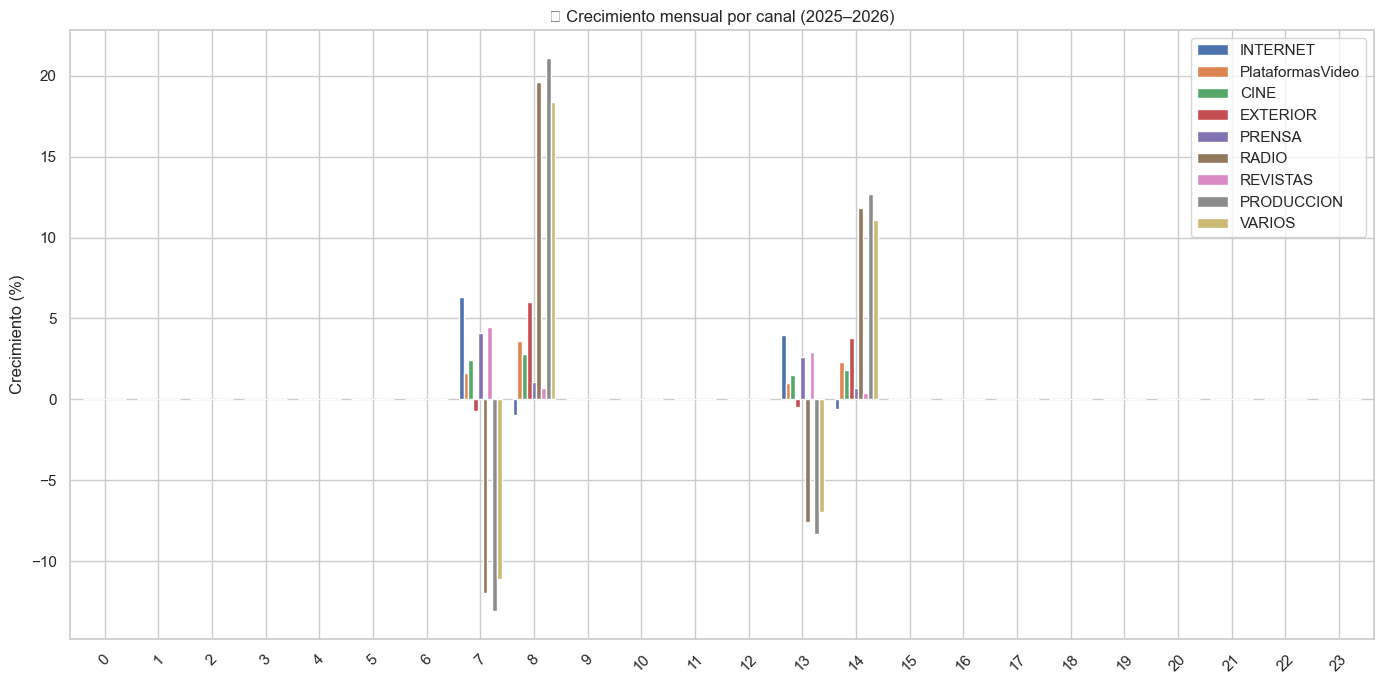

In [343]:
import cvxpy as cp
import pandas as pd
import matplotlib.pyplot as plt

# Asegurar formato de fecha correcto
df_combined['Fecha'] = pd.to_datetime(df_combined['Fecha'], errors='coerce')

# ---------------------------------------
# Función de optimización de inversión
# ---------------------------------------
def optimizar_inversion(monto, coef_opt, canales, limites):
    x = cp.Variable(len(canales))
    coefs_array = coef_opt.values

    constraints = [cp.sum(x) == monto]
    for i, canal in enumerate(canales):
        if 'min' in limites.get(canal, {}):
            constraints.append(x[i] >= limites[canal]['min'] * monto)
        if 'max' in limites.get(canal, {}):
            constraints.append(x[i] <= limites[canal]['max'] * monto)
    constraints.append(x >= 0)

    objective = cp.Maximize(coefs_array @ x)
    prob = cp.Problem(objective, constraints)
    prob.solve()

    return pd.Series(x.value, index=canales)

# ---------------------------------------
# Función para ajustar por eventos
# ---------------------------------------
def apply_event_adjustment(month, sales_proj):
    easter = 1.1 if month in df_combined[df_combined['Semana_Santa'] == 1]['Fecha'].dt.month.values else 1.0
    weekend = 1.05 if month in df_combined[df_combined['Dias_fines_semana'] > 0]['Fecha'].dt.month.values else 1.0
    working = 1.02 if month in df_combined[df_combined['working_days'] > 0]['Fecha'].dt.month.values else 1.0
    return sales_proj * easter * weekend * working

# ---------------------------------------
# Presupuesto base y límites
# ---------------------------------------
budget_2024 = df_combined[channels].sum(axis=1).mean()

limites_por_canal = {
    'INTERNET': {'max': 0.70},
    'PlataformasVideo': {'min': 0.075},
    'CINE': {'min': 0.05},
    'EXTERIOR': {'min': 0.04},
    'PRENSA': {'min': 0.08},
    'RADIO': {'min': 0.04},
    'REVISTAS': {'min': 0.02},
    'PRODUCCION': {'min': 0.03},
    'VARIOS': {'min': 0.02}
}

# ---------------------------------------
# Rango de simulación: 2025–2026
# ---------------------------------------
sim_months_full = pd.date_range(start='2025-01-01', end='2026-12-01', freq='MS')

# Inicializar lags
inv_lag1 = optimized_investment_series.copy()
inv_lag2 = optimized_investment_series.copy()

# Resultados
results_full = []

# Iteración sobre los meses
for current_month in sim_months_full:
    year = current_month.year
    month_str = current_month.strftime('%Y-%m')

    # Presupuesto mensual
    if year == 2025:
        if current_month.month <= 6:
            monthly_budget = budget_2024 * 1.15
        else:
            monthly_budget = budget_2024 * 1.21
    elif year == 2026:
        monthly_budget = budget_2024 * 1.25
    else:
        monthly_budget = budget_2024

    # Optimización de inversión
    optimized_investment_series = optimizar_inversion(
        monthly_budget,
        coef_opt,
        channels,
        limites_por_canal
    )

    # Proyección de ventas por canal
    sales_proj = 0
    for ch in channels:
        c1 = coef.get(f'{ch}_lag1', 0)
        c2 = coef.get(f'{ch}_lag2', 0)
        sales_proj += c1 * inv_lag1[ch] + c2 * inv_lag2[ch]

    # Ajuste por eventos
    sales_proj = apply_event_adjustment(current_month.month, sales_proj)

    results_full.append({
        'Mes': month_str,
        'Inversión total (€)': round(optimized_investment_series.sum(), 2),
        'Ventas esperadas': round(sales_proj, 2),
        **{ch: optimized_investment_series[ch] for ch in channels},  # Inversión por canal
        **{f'Ventas_{ch}': coef.get(f'{ch}_lag1', 0) * inv_lag1[ch] + coef.get(f'{ch}_lag2', 0) * inv_lag2[ch] for ch in channels}  # Ventas por canal
    })

    # Actualizar lags
    inv_lag2 = inv_lag1.copy()
    inv_lag1 = optimized_investment_series.copy()

# ---------------------------------------
# DataFrame de resultados
# ---------------------------------------
df_results_full = pd.DataFrame(results_full)
df_results_full['Ventas acumuladas'] = df_results_full['Ventas esperadas'].cumsum()
df_results_full['Crecimiento mensual (%)'] = df_results_full['Ventas esperadas'].pct_change().fillna(0).round(3) * 100

# Mostrar todo
print("\n📈 Simulación completa (2025–2026):")
print(df_results_full)

# Mostrar resultados de 2026
print("\n📅 Resultados de 2026:")
print(df_results_full[df_results_full['Mes'].str.startswith('2026')])

# Mostrar crecimiento anual
ventas_2025 = df_results_full[df_results_full['Mes'].str.startswith('2025')]['Ventas esperadas'].sum()
ventas_2026 = df_results_full[df_results_full['Mes'].str.startswith('2026')]['Ventas esperadas'].sum()
crecimiento_anual = ((ventas_2026 / ventas_2025) - 1) * 100
print(f"\n🚀 Crecimiento anual esperado 2026 vs 2025: {crecimiento_anual:.2f}%")

# ---------------------------------------
# GRÁFICAS (desglosadas por canal)
# ---------------------------------------

# 1️⃣ Inversión por canal a lo largo del tiempo
df_results_full.set_index('Mes')[channels].plot(kind='line', figsize=(14, 7), marker='o')
plt.title("📊 Inversión mensual por canal (2025–2026)")
plt.ylabel("Inversión (€)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# 2️⃣ Ventas por canal a lo largo del tiempo
df_results_full.set_index('Mes')[['Ventas_' + ch for ch in channels]].plot(kind='line', figsize=(14, 7), marker='s')
plt.title("📊 Ventas proyectadas por canal (2025–2026)")
plt.ylabel("Ventas (€)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# 3️⃣ Crecimiento mensual por canal
growth_by_channel = pd.DataFrame({
    ch: df_results_full[f'Ventas_{ch}'].pct_change().fillna(0).round(3) * 100
    for ch in channels
})
growth_by_channel.plot(kind='bar', figsize=(14, 7), stacked=False, width=0.8)
plt.title("📈 Crecimiento mensual por canal (2025–2026)")
plt.ylabel("Crecimiento (%)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [344]:
# -------------------------------------------
# 🧪 FUNCIÓN DE SIMULADOR DE ESCENARIOS
# -------------------------------------------
def simular_escenario(ajustes_porcentuales, meses=6):
    inv_lag1 = optimized_investment_series.copy()
    inv_lag2 = optimized_investment_series.copy()
    resultados = []

    sim_months = pd.date_range(start='2025-01-01', periods=meses, freq='MS')

    for current_month in sim_months:
        current_month_str = current_month.strftime('%Y-%m')
        monthly_budget = presupuestos.get(current_month_str, budget_2024 * 1.15)

        # Reoptimizar con presupuesto actualizado
        constraints[0] = cp.sum(x) == monthly_budget
        prob = cp.Problem(objective, constraints)
        prob.solve()
        optimized_base = pd.Series(x.value, index=channels)

        # Aplicar ajustes por canal
        for canal, factor in ajustes_porcentuales.items():
            optimized_base[canal] *= factor

        # Asegurar que suma total se ajusta al presupuesto
        optimized_base *= monthly_budget / optimized_base.sum()

        # Calcular ventas proyectadas
        sales_proj = 0
        for ch in channels:
            c1 = coef.get(f'{ch}_lag1', 0)
            c2 = coef.get(f'{ch}_lag2', 0)
            sales_proj += c1 * inv_lag1[ch] + c2 * inv_lag2[ch]

        sales_proj = apply_event_adjustment(current_month.month, sales_proj)

        resultados.append({
            'Mes': current_month.strftime('%Y-%m'),
            'Ventas esperadas': round(sales_proj, 2),
            'Inversión total': round(optimized_base.sum(), 2)
        })

        # Desplazar inversiones
        inv_lag2 = inv_lag1.copy()
        inv_lag1 = optimized_base.copy()

    df_escenario = pd.DataFrame(resultados)
    df_escenario['Ventas acumuladas'] = df_escenario['Ventas esperadas'].cumsum()
    return df_escenario


In [345]:
# Escenario 1: Subir 20% CINE, bajar 10% PRENSA
escenario_1 = simular_escenario({'CINE': 1.2, 'PRENSA': 0.9})
print("\n🎬 Escenario 1:")
print(escenario_1)

# Escenario 2: Reducción general 10% en todo lo tradicional
escenario_2 = simular_escenario({
    'CINE': 0.9, 'PRENSA': 0.9, 'RADIO': 0.9, 'REVISTAS': 0.9, 'EXTERIOR': 0.9
})
print("\n📻 Escenario 2:")
print(escenario_2)

# Escenario 3: Aumentar 30% solo en internet
escenario_3 = simular_escenario({'INTERNET': 1.3})
print("\n🌐 Escenario 3:")
print(escenario_3)



🎬 Escenario 1:
       Mes  Ventas esperadas  Inversión total  Ventas acumuladas
0  2025-01       19225296.31        663046.37       1.922530e+07
1  2025-02       17264883.35        663046.37       3.649018e+07
2  2025-03       18924015.29        663046.37       5.541419e+07
3  2025-04       18924015.29        663046.37       7.433821e+07
4  2025-05       17203650.27        663046.37       9.154186e+07
5  2025-06       17203650.27        663046.37       1.087455e+08

📻 Escenario 2:
       Mes  Ventas esperadas  Inversión total  Ventas acumuladas
0  2025-01       19225296.31        663046.37       1.922530e+07
1  2025-02       18149453.58        663046.37       3.737475e+07
2  2025-03       20172411.87        663046.37       5.754716e+07
3  2025-04       20172411.87        663046.37       7.771957e+07
4  2025-05       18338556.24        663046.37       9.605813e+07
5  2025-06       18338556.24        663046.37       1.143967e+08

🌐 Escenario 3:
       Mes  Ventas esperadas  Inversión to

### Comparacion 

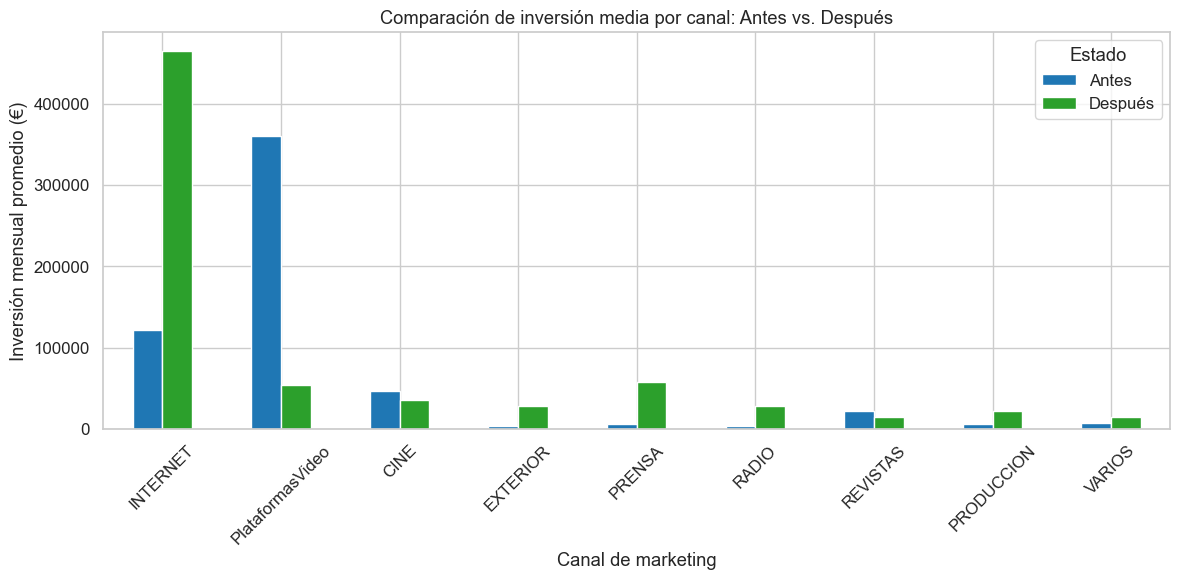

In [346]:
import matplotlib.pyplot as plt
import seaborn as sns

# Estilo general
sns.set(style="whitegrid", font_scale=1.1)

# 1. Inversión media histórica (antes)
historical_mean = df_combined[channels].mean()
historical_mean.name = "Antes"

# 2. Inversión optimizada (después)
optimized_mean = inv_lag1.copy()
optimized_mean.name = "Después"

# 3. Comparación en un solo DataFrame
df_compare = pd.concat([historical_mean, optimized_mean], axis=1)

# 4. Gráfico de comparación
df_compare.plot(kind='bar', figsize=(12, 6), color=['#1f77b4', '#2ca02c'])
plt.title("Comparación de inversión media por canal: Antes vs. Después")
plt.ylabel("Inversión mensual promedio (€)")
plt.xlabel("Canal de marketing")
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(title="Estado")
plt.show()


C:\Users\aserr\AppData\Local\Temp\ipykernel_8028\2282653330.py:32: UserWarning: Glyph 128161 (\N{ELECTRIC LIGHT BULB}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\aserr\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128161 (\N{ELECTRIC LIGHT BULB}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


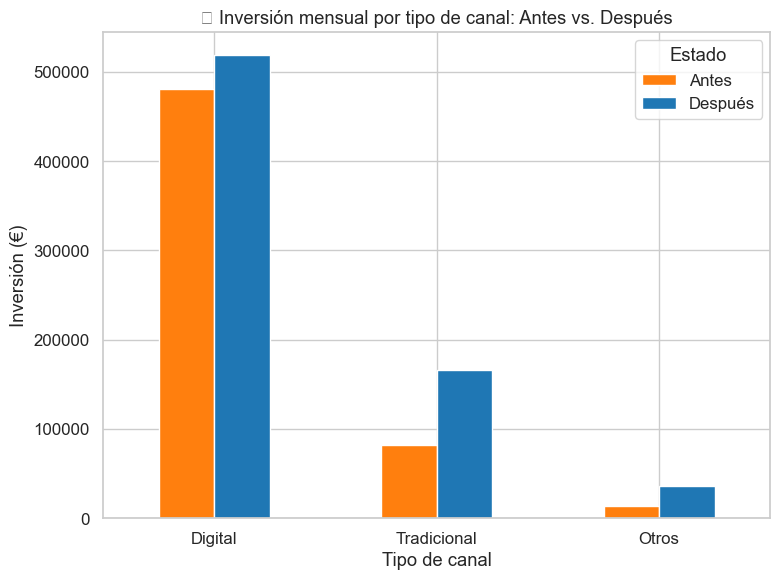

In [347]:
grupos = {
    'Digital': ['INTERNET', 'PlataformasVideo'],
    'Tradicional': ['PRENSA', 'RADIO', 'REVISTAS', 'CINE', 'EXTERIOR'],
    'Otros': ['PRODUCCION', 'VARIOS']
}
# Calcular inversión media histórica agrupada
historical_grouped = {
    grupo: df_combined[canales].mean().sum() for grupo, canales in grupos.items()
}

# Calcular inversión optimizada agrupada
optimized_grouped = {
    grupo: inv_lag1[canales].sum() for grupo, canales in grupos.items()
}

# Crear DataFrame comparativo
df_grouped_compare = pd.DataFrame({
    'Antes': historical_grouped,
    'Después': optimized_grouped
}).T

# Transponer para el gráfico
df_grouped_compare = df_grouped_compare.T

# Graficar
df_grouped_compare.plot(kind='bar', figsize=(8, 6), color=['#ff7f0e', '#1f77b4'])
plt.title("💡 Inversión mensual por tipo de canal: Antes vs. Después")
plt.ylabel("Inversión (€)")
plt.xlabel("Tipo de canal")
plt.xticks(rotation=0)
plt.legend(title="Estado")
plt.tight_layout()
plt.show()


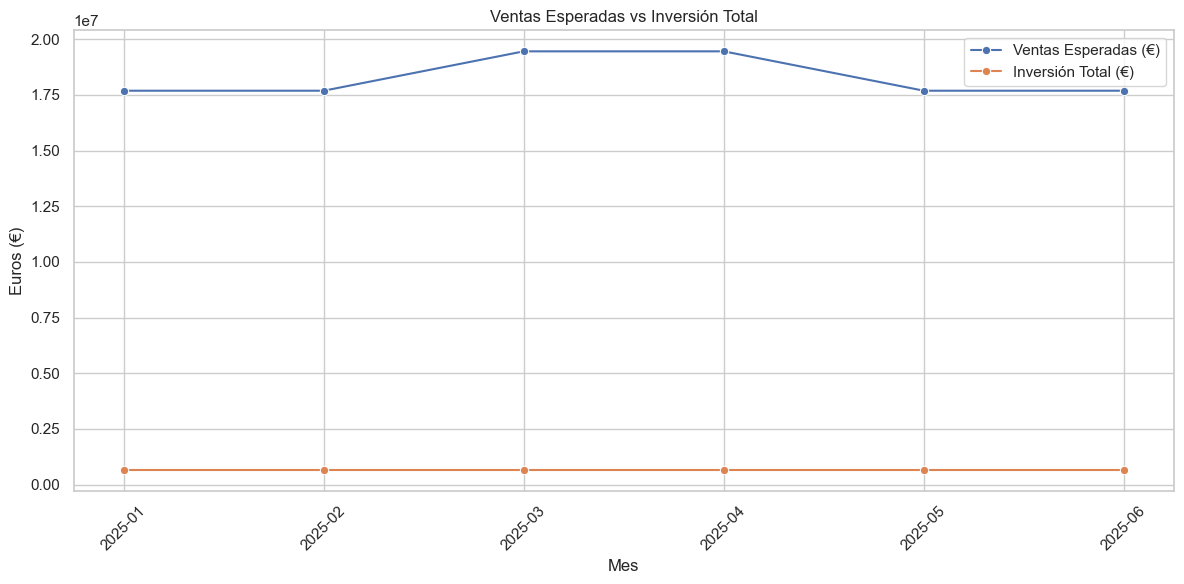

C:\Users\aserr\AppData\Local\Temp\ipykernel_8028\1238681474.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Mes", y="Crecimiento mensual (%)", data=df_results, palette="viridis")


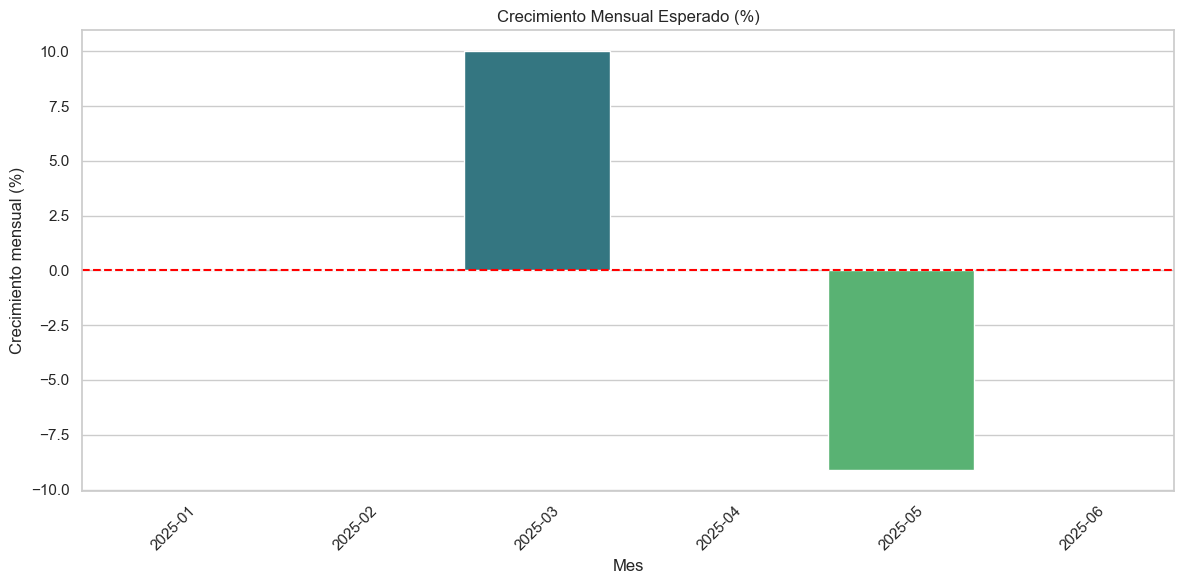

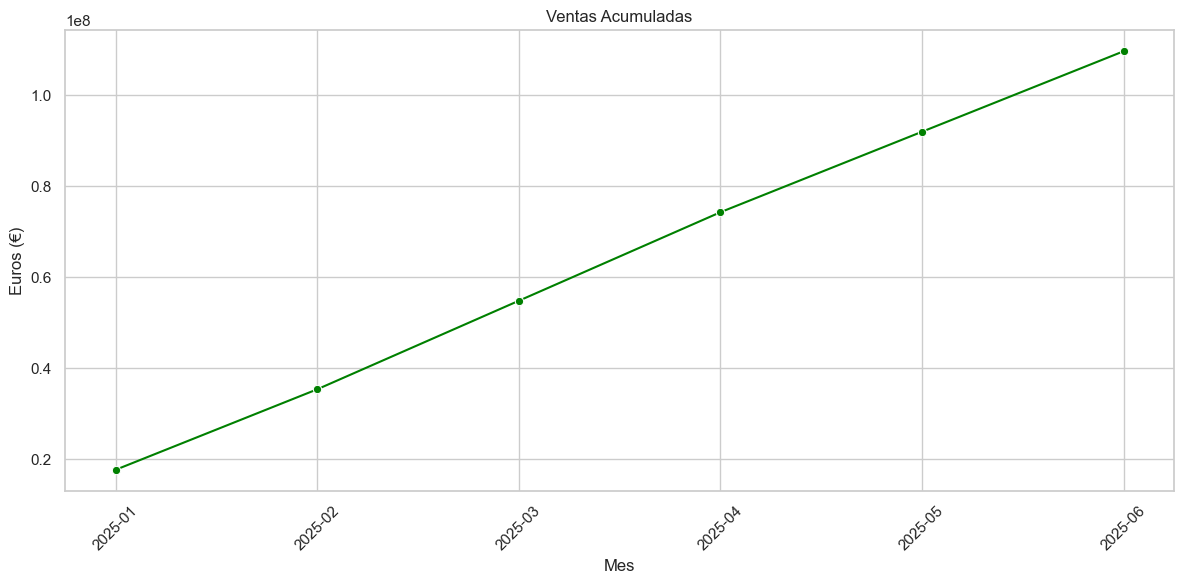

In [348]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de estilo
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# 1️⃣ Ventas esperadas vs Inversión total
plt.figure()
sns.lineplot(x="Mes", y="Ventas esperadas", data=df_results, label="Ventas Esperadas (€)", marker='o')
sns.lineplot(x="Mes", y="Inversión total", data=df_results, label="Inversión Total (€)", marker='o')
plt.xticks(rotation=45)
plt.title("Ventas Esperadas vs Inversión Total")
plt.ylabel("Euros (€)")
plt.legend()
plt.tight_layout()
plt.show()

# 2️⃣ Crecimiento mensual esperado (%)
plt.figure()
sns.barplot(x="Mes", y="Crecimiento mensual (%)", data=df_results, palette="viridis")
plt.xticks(rotation=45)
plt.title("Crecimiento Mensual Esperado (%)")
plt.axhline(0, color='red', linestyle='--')
plt.tight_layout()
plt.show()

# 3️⃣ Ventas acumuladas
plt.figure()
sns.lineplot(x="Mes", y="Ventas acumuladas", data=df_results, color='green', marker='o')
plt.xticks(rotation=45)
plt.title("Ventas Acumuladas")
plt.ylabel("Euros (€)")
plt.tight_layout()
plt.show()


C:\Users\aserr\AppData\Local\Temp\ipykernel_8028\2432450456.py:34: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\aserr\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


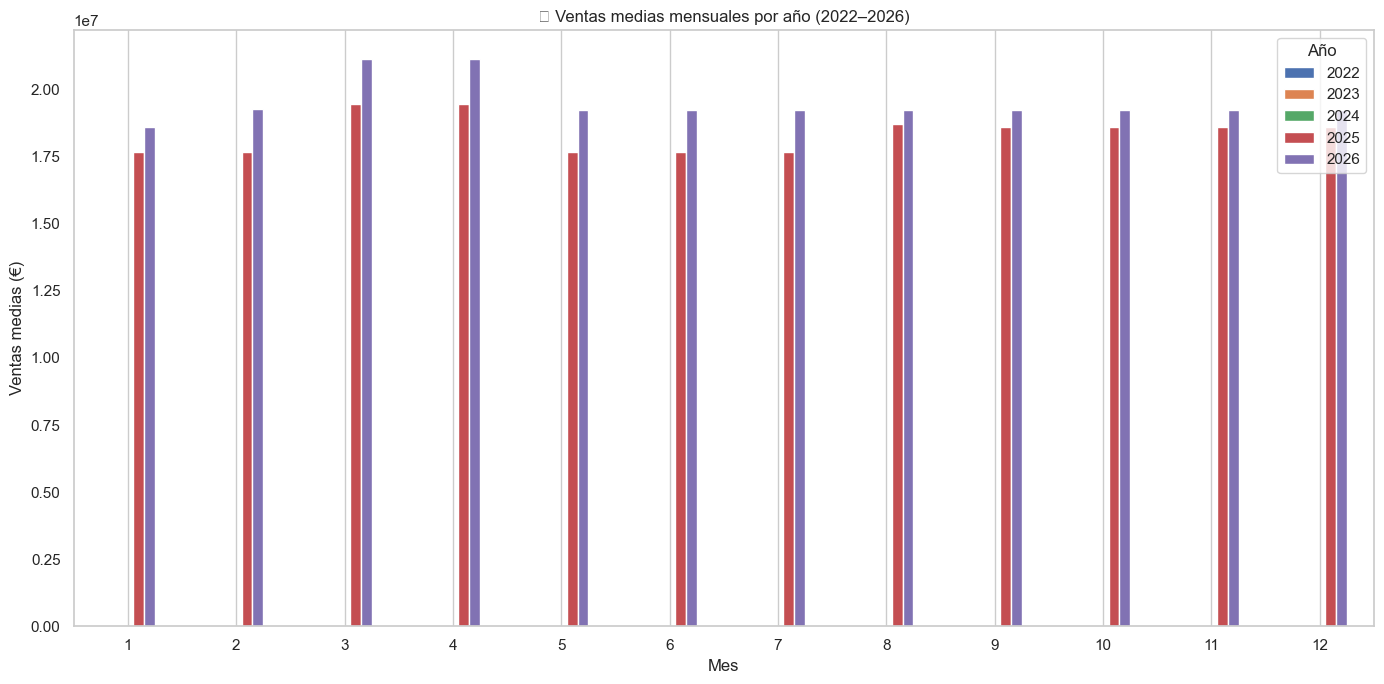

In [349]:
import matplotlib.pyplot as plt

# Asegurar formato de fecha
df_combined['Fecha'] = pd.to_datetime(df_combined['Fecha'])
df_combined['Año'] = df_combined['Fecha'].dt.year
df_combined['Mes'] = df_combined['Fecha'].dt.month

# Agrupar ventas reales por año y mes
ventas_reales = df_combined.groupby(['Año', 'Mes'])['Sales'].mean().reset_index()

# Agregar predicciones
df_results_full['Año'] = pd.to_datetime(df_results_full['Mes']).dt.year
df_results_full['Mes'] = pd.to_datetime(df_results_full['Mes']).dt.month

ventas_pred = df_results_full.groupby(['Año', 'Mes'])['Ventas esperadas'].mean().reset_index()
ventas_pred.rename(columns={'Ventas esperadas': 'Sales'}, inplace=True)

# Combinar
df_ventas_total = pd.concat([ventas_reales, ventas_pred])
df_ventas_total = df_ventas_total[df_ventas_total['Año'].isin([2022, 2023, 2024, 2025, 2026])]

# Pivot para gráfico
df_pivot = df_ventas_total.pivot(index='Mes', columns='Año', values='Sales')
df_pivot = df_pivot.sort_index()

# Plot
df_pivot.plot(kind='bar', figsize=(14, 7))
plt.title('📅 Ventas medias mensuales por año (2022–2026)')
plt.ylabel('Ventas medias (€)')
plt.xlabel('Mes')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.legend(title='Año')
plt.tight_layout()
plt.show()



📋 Ventas medias mensuales por año:

Año    2022    2023    2024
Mes                        
1       NaN  1072.0  1880.0
2    1752.0  1633.0  2237.0
3    1897.0  1545.0  2195.0
4    1546.0  1145.0  1663.0
5    1784.0  2107.0  1964.0
6    1818.0  1870.0  1784.0
7    1583.0  1696.0  1826.0
8    1142.0  1447.0  2202.0
9    1541.0  1618.0  1641.0
10   1586.0  1704.0  1863.0
11   1562.0  2147.0  1883.0
12   1817.0  2163.0  1897.0


C:\Users\aserr\AppData\Local\Temp\ipykernel_8028\312592734.py:42: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\aserr\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


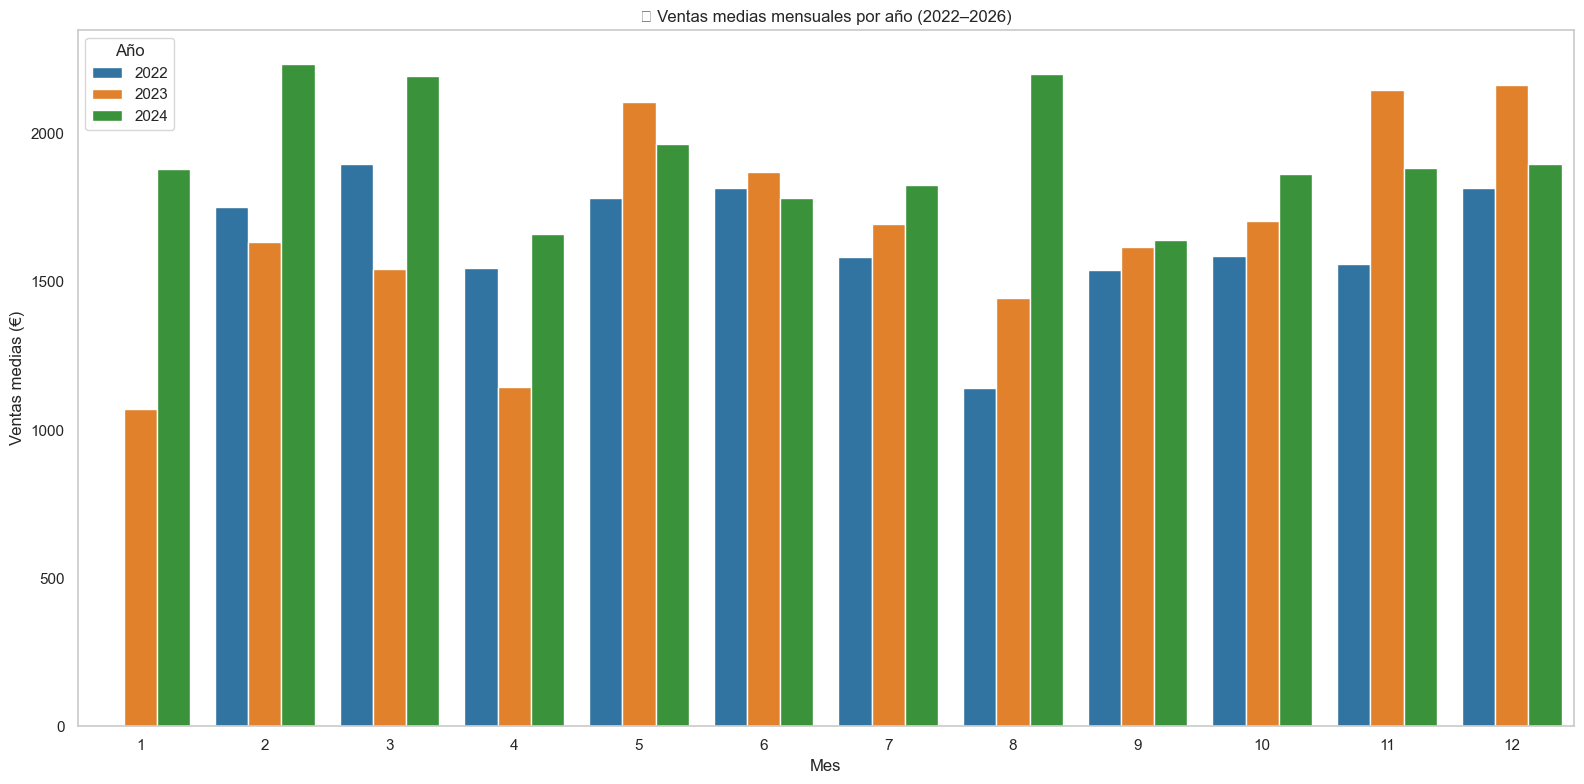

In [350]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Asegurar formatos
df_combined['Fecha'] = pd.to_datetime(df_combined['Fecha'])
df_combined['Año'] = df_combined['Fecha'].dt.year
df_combined['Mes'] = df_combined['Fecha'].dt.month

df_results_full['Mes'] = pd.to_datetime(df_results_full['Mes'])
df_results_full['Año'] = df_results_full['Mes'].dt.year
df_results_full['Mes_num'] = df_results_full['Mes'].dt.month

# 1. Agrupar datos reales (2022–2024)
ventas_reales_mensuales = df_combined[df_combined['Año'].isin([2022, 2023, 2024])]
ventas_reales_mensuales = ventas_reales_mensuales.groupby(['Año', 'Mes'])['Sales'].mean().reset_index()
ventas_reales_mensuales.rename(columns={'Sales': 'Ventas medias'}, inplace=True)

# 2. Agrupar predicciones (2025–2026)
ventas_pred_mensuales = df_results_full[df_results_full['Año'].isin([2025, 2026])]
ventas_pred_mensuales = ventas_pred_mensuales.groupby(['Año', 'Mes_num'])['Ventas esperadas'].mean().reset_index()
ventas_pred_mensuales.rename(columns={'Mes_num': 'Mes', 'Ventas esperadas': 'Ventas medias'}, inplace=True)

# 3. Combinar ambos
ventas_mensuales_total = pd.concat([ventas_reales_mensuales, ventas_pred_mensuales])
ventas_mensuales_total.sort_values(by=['Año', 'Mes'], inplace=True)

# 4. Mostrar tabla de ventas mensuales por año
print("\n📋 Ventas medias mensuales por año:\n")
pivot_table = ventas_mensuales_total.pivot(index='Mes', columns='Año', values='Ventas medias')
print(pivot_table.round(2))

# 5. Graficar
plt.figure(figsize=(16, 8))
sns.barplot(data=ventas_mensuales_total, x='Mes', y='Ventas medias', hue='Año', palette='tab10')

plt.title('📊 Ventas medias mensuales por año (2022–2026)')
plt.xlabel('Mes')
plt.ylabel('Ventas medias (€)')
plt.legend(title='Año')
plt.grid(axis='y')
plt.tight_layout()
plt.show()



📋 Ventas medias mensuales por año:

Año    2022    2023    2024
Mes                        
1       NaN  1072.0  1880.0
2    1752.0  1633.0  2237.0
3    1897.0  1545.0  2195.0
4    1546.0  1145.0  1663.0
5    1784.0  2107.0  1964.0
6    1818.0  1870.0  1784.0
7    1583.0  1696.0  1826.0
8    1142.0  1447.0  2202.0
9    1541.0  1618.0  1641.0
10   1586.0  1704.0  1863.0
11   1562.0  2147.0  1883.0
12   1817.0  2163.0  1897.0


C:\Users\aserr\AppData\Local\Temp\ipykernel_8028\621804267.py:57: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\aserr\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


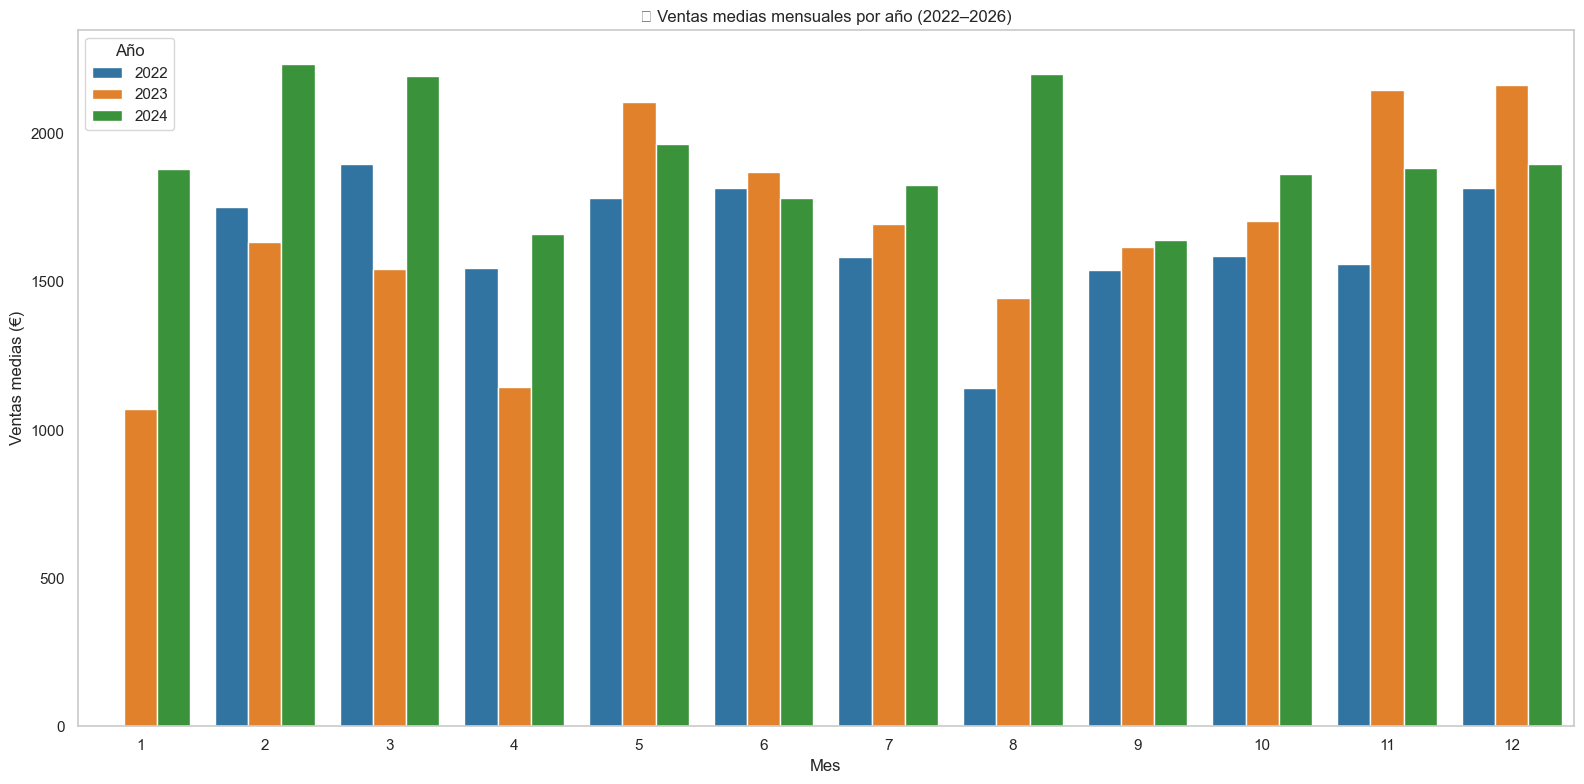

In [351]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Asegurar que las fechas están bien
df_combined['Fecha'] = pd.to_datetime(df_combined['Fecha'])
df_combined['Año'] = df_combined['Fecha'].dt.year
df_combined['Mes'] = df_combined['Fecha'].dt.month

df_results_full['Mes'] = pd.to_datetime(df_results_full['Mes'])
df_results_full['Año'] = df_results_full['Mes'].dt.year
df_results_full['Mes_num'] = df_results_full['Mes'].dt.month

# --------------------------
# DATOS REALES: 2022–2024
# --------------------------
ventas_reales = df_combined[df_combined['Año'].isin([2022, 2023, 2024])]
ventas_reales_grouped = ventas_reales.groupby(['Año', 'Mes'])['Sales'].mean().reset_index()
ventas_reales_grouped.rename(columns={'Sales': 'Ventas medias'}, inplace=True)

# --------------------------
# PREDICCIONES: 2025–2026
# --------------------------
# Asegura que el nombre de columna sea correcto
col_pred = 'Ventas esperadas'
if col_pred not in df_results_full.columns:
    print(f"⚠️ La columna '{col_pred}' no existe en df_results_full. Usa: {df_results_full.columns.tolist()}")

ventas_pred = df_results_full[df_results_full['Año'].isin([2025, 2026])]
ventas_pred_grouped = ventas_pred.groupby(['Año', 'Mes_num'])[col_pred].mean().reset_index()
ventas_pred_grouped.rename(columns={'Mes_num': 'Mes', col_pred: 'Ventas medias'}, inplace=True)

# --------------------------
# COMBINAR TODO
# --------------------------
ventas_mensuales_total = pd.concat([ventas_reales_grouped, ventas_pred_grouped], ignore_index=True)
ventas_mensuales_total.sort_values(by=['Año', 'Mes'], inplace=True)

# --------------------------
# TABLA FINAL
# --------------------------
print("\n📋 Ventas medias mensuales por año:\n")
tabla = ventas_mensuales_total.pivot(index='Mes', columns='Año', values='Ventas medias')
print(tabla.round(2))

# --------------------------
# GRÁFICO
# --------------------------
plt.figure(figsize=(16, 8))
sns.barplot(data=ventas_mensuales_total, x='Mes', y='Ventas medias', hue='Año', palette='tab10')

plt.title('📊 Ventas medias mensuales por año (2022–2026)')
plt.xlabel('Mes')
plt.ylabel('Ventas medias (€)')
plt.legend(title='Año')
plt.grid(axis='y')
plt.tight_layout()
plt.show()



📋 Ventas medias mensuales por año:

Año    2022    2023    2024
Mes                        
1       NaN  1072.0  1880.0
2    1752.0  1633.0  2237.0
3    1897.0  1545.0  2195.0
4    1546.0  1145.0  1663.0
5    1784.0  2107.0  1964.0
6    1818.0  1870.0  1784.0
7    1583.0  1696.0  1826.0
8    1142.0  1447.0  2202.0
9    1541.0  1618.0  1641.0
10   1586.0  1704.0  1863.0
11   1562.0  2147.0  1883.0
12   1817.0  2163.0  1897.0


C:\Users\aserr\AppData\Local\Temp\ipykernel_8028\1703120239.py:52: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\aserr\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


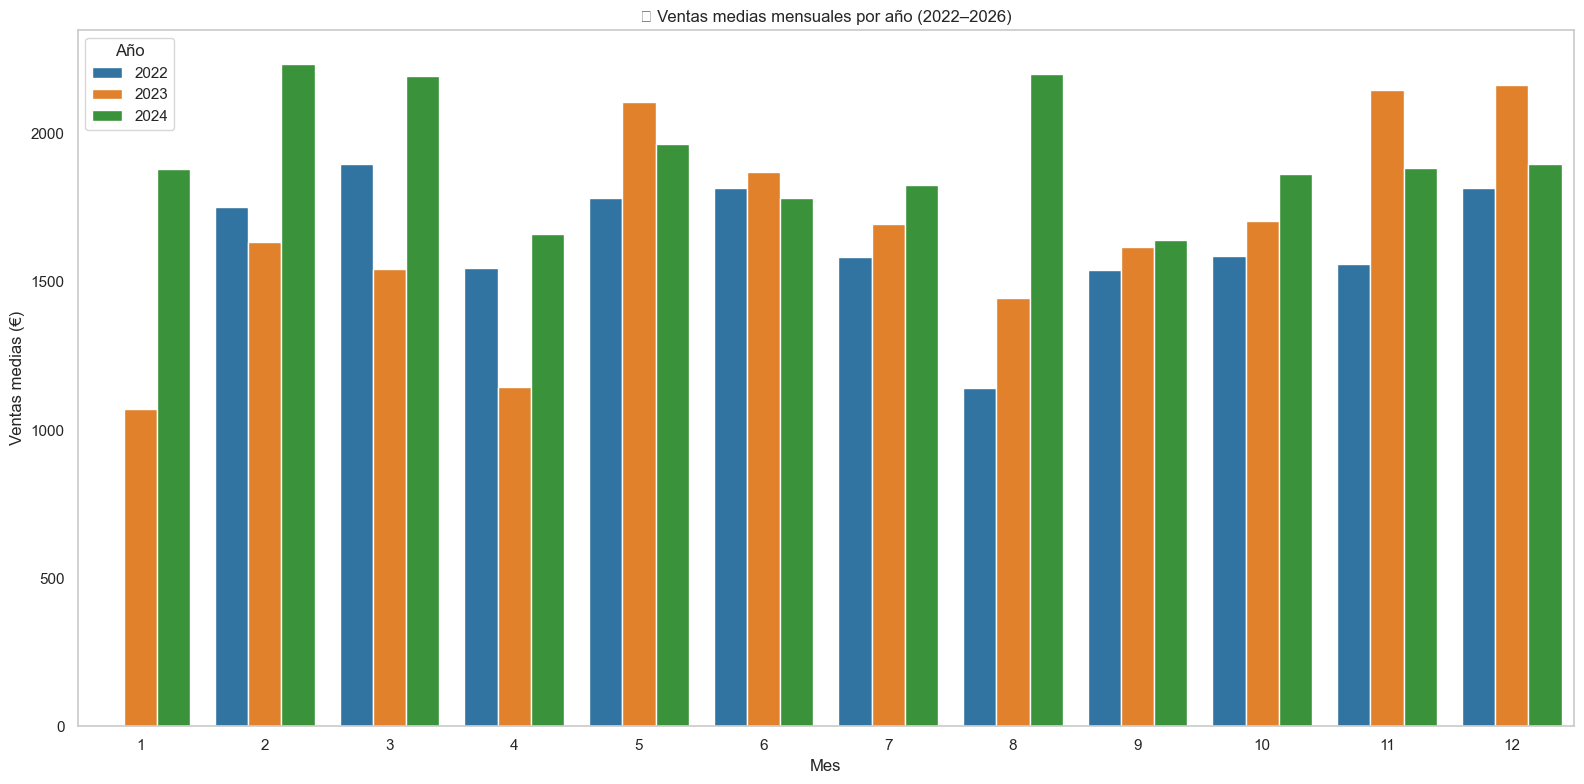

In [352]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Asegurar fechas
df_combined['Fecha'] = pd.to_datetime(df_combined['Fecha'])
df_combined['Año'] = df_combined['Fecha'].dt.year
df_combined['Mes'] = df_combined['Fecha'].dt.month

df_results_full['Mes'] = pd.to_datetime(df_results_full['Mes'])
df_results_full['Año'] = df_results_full['Mes'].dt.year
df_results_full['Mes_num'] = df_results_full['Mes'].dt.month

# --------------------------
# DATOS REALES: 2022–2024
# --------------------------
ventas_reales = df_combined[df_combined['Año'].isin([2022, 2023, 2024])]
ventas_reales_grouped = ventas_reales.groupby(['Año', 'Mes'])['Sales'].mean().reset_index()
ventas_reales_grouped.rename(columns={'Sales': 'Ventas medias'}, inplace=True)

# --------------------------
# PREDICCIONES: 2025–2026
# --------------------------
ventas_pred = df_results_full[df_results_full['Año'].isin([2025, 2026])]
ventas_pred_grouped = ventas_pred.groupby(['Año', 'Mes_num'])['Ventas esperadas'].mean().reset_index()
ventas_pred_grouped.rename(columns={'Mes_num': 'Mes', 'Ventas esperadas': 'Ventas medias'}, inplace=True)

# --------------------------
# COMBINAR TODO
# --------------------------
df_ventas_total = pd.concat([ventas_reales_grouped, ventas_pred_grouped], ignore_index=True)
df_ventas_total = df_ventas_total[df_ventas_total['Año'].isin([2022, 2023, 2024, 2025, 2026])]

# --------------------------
# TABLA RESUMEN
# --------------------------
tabla = df_ventas_total.pivot(index='Mes', columns='Año', values='Ventas medias').sort_index()
print("\n📋 Ventas medias mensuales por año:\n")
print(tabla.round(2))

# --------------------------
# GRÁFICO
# --------------------------
plt.figure(figsize=(16, 8))
sns.barplot(data=df_ventas_total, x='Mes', y='Ventas medias', hue='Año', palette='tab10')

plt.title('📊 Ventas medias mensuales por año (2022–2026)')
plt.xlabel('Mes')
plt.ylabel('Ventas medias (€)')
plt.legend(title='Año')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


por mes 


In [353]:
import pandas as pd

# Coeficientes del modelo (copiados desde tu output)
coef_dict = {
    'INTERNET_lag1': 43.232539, 'PlataformasVideo_lag1': 20.386191, 'CINE_lag1': -25.238985,
    'EXTERIOR_lag1': 0.725433, 'PRENSA_lag1': 7.512902, 'RADIO_lag1': -13.650519,
    'REVISTAS_lag1': -53.830824, 'PRODUCCION_lag1': 1.315158, 'VARIOS_lag1': 16.520303,
    'INTERNET_lag2': -7.222414, 'PlataformasVideo_lag2': 47.390314, 'CINE_lag2': -30.366196,
    'EXTERIOR_lag2': -5.865393, 'PRENSA_lag2': 2.054115, 'RADIO_lag2': 19.575220,
    'REVISTAS_lag2': -8.583348, 'PRODUCCION_lag2': -1.837761, 'VARIOS_lag2': -24.267852
}

coef_series = pd.Series(coef_dict)

# Agrupar por canal sumando sus lags
total_impact = coef_series.groupby(lambda x: x.split('_')[0]).sum()
total_impact = total_impact.sort_values(ascending=False)


In [354]:
# Valores de inversión promedio (copiados de tu output)
inversion = pd.Series({
    'INTERNET': 464853.16,
    'PlataformasVideo': 54052.69,
    'CINE': 36035.13,
    'EXTERIOR': 28828.10,
    'PRENSA': 57656.21,
    'RADIO': 28828.10,
    'REVISTAS': 14414.05,
    'PRODUCCION': 21621.08,
    'VARIOS': 14414.05
})

# Impacto marginal por euro invertido
impacto_marginal = total_impact / inversion
impacto_marginal = impacto_marginal.sort_values(ascending=False)
